# Question 1

In [ ]:
import math 
import numpy as np
from sklearn.linear_model import Lasso, LassoCV
import sklearn
from matplotlib import pyplot as plt

### point1

In [ ]:
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]


def train_test_split(X,y, train_frac=0.8):
    N = int(X.shape[0]*train_frac)
    X_train = X[:N] 
    X_val = X[N:]
    y_train = y[:N]
    y_val =  y[N:]
    return X_train, y_train, X_val, y_val

In [ ]:
n = 250
p = 500
rng = np.random
sparsity = 0.85
X, y, beta = simulate_data(n,p,rng,sparsity = sparsity)
X_train, y_train, X_val, y_val = train_test_split(X,y)

### point2

In [ ]:
def create_samples(X,y, M, frac=1):
    samples_X = []
    samples_y = []
    for m in range(M):
        N_rows = int(X.shape[0]*frac)
        selected_idx = np.random.choice(np.arange(X.shape[0]), size=N_rows, replace=True)
        samples_X.append(X[selected_idx])
        samples_y.append(y[selected_idx])
    return np.array(samples_X), np.array(samples_y)

N_Samples = 30
#samples_X, samples_y = create_samples(X_train, y_train, N_Samples)
#print(samples_X.shape)

In [ ]:
def select_features(samples_X,samples_y, add_to_idx=0, test_alpha_min=False):
    
    n_folds = 5 
    times_selected = np.zeros(samples_X.shape[2])

    for i in range(samples_X.shape[0]): 
        X, y = samples_X[i], samples_y[i]
        lassoCV = LassoCV(cv=n_folds, random_state=0).fit(X,y)
        alpha = lassoCV.alpha_
        
        cv_mean = np.mean(lassoCV.mse_path_, axis=1)
        cv_std = np.std(lassoCV.mse_path_, axis=1)
        idx_min_mean = np.argmin(cv_mean)
        idx_alpha = np.where(
            (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
            (cv_mean >= cv_mean[idx_min_mean])
        )[0][0]
        alpha_1se = lassoCV.alphas_[idx_alpha + add_to_idx]
        if(test_alpha_min):
            alpha_1se = alpha

        lasso_coef = Lasso(alpha= alpha, random_state=0).fit(X_train,y_train).coef_
        lasso_coef = np.array(lasso_coef)
        lasso_1se_coef = Lasso(alpha= alpha_1se, random_state=0).fit(X_train,y_train).coef_
        lasso_1se_coef = np.array(lasso_1se_coef)
        times_selected += lasso_1se_coef != 0
        #print(times_selected)
    return times_selected




### point3/5

In [ ]:
print(samples_X.shape)

(30, 200, 500)


In [ ]:
#times_selected = select_features(samples_X,samples_y,test_alpha_min=True)
#times_selected.shape
#plt.figure(figsize=(6,5))
#plt.bar(np.arange(times_selected.shape[0]), times_selected,width = 2)

In [ ]:
times_selected = select_features(samples_X,samples_y)
times_selected_plus1 = select_features(samples_X,samples_y, add_to_idx=1)
times_selected_minus1 = select_features(samples_X,samples_y, add_to_idx=-1)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e+02, tolerance: 6.458e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.392e+01, tolerance: 5.537e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of t

<BarContainer object of 500 artists>

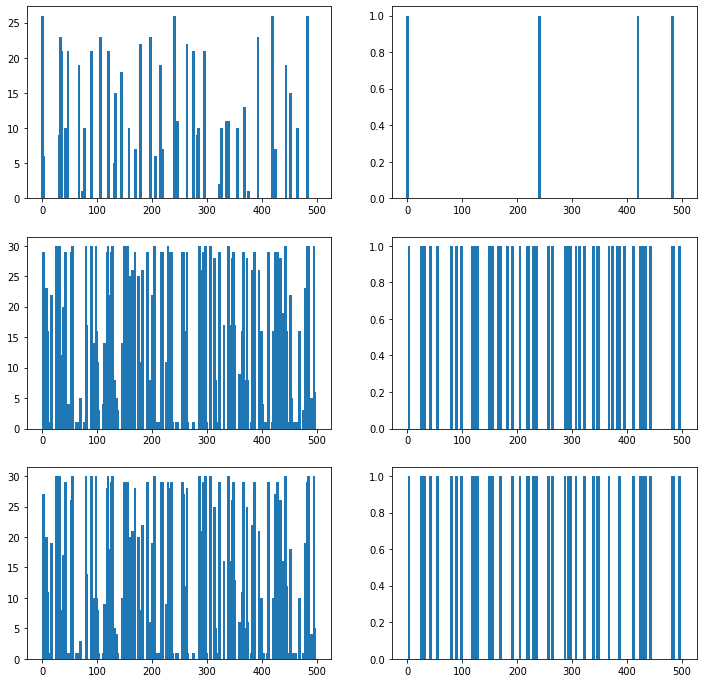

In [ ]:
THRESHOLD = 85


times_selected_with_threshold = 100*np.array(times_selected)/N_Samples >= THRESHOLD
times_selected_with_threshold_p1 = 100*np.array(times_selected_plus1)/N_Samples >= THRESHOLD
times_selected_with_threshold_m1 = 100*np.array(times_selected_minus1)/N_Samples >= THRESHOLD

plt.figure(figsize=(12,12))
plt.subplot(323)
plt.bar(np.arange(times_selected_plus1.shape[0]), times_selected_plus1, width=5)
plt.subplot(324)
plt.bar(np.arange(times_selected_with_threshold_p1.shape[0]), times_selected_with_threshold_p1, width=5)

plt.subplot(321)
plt.bar(np.arange(times_selected.shape[0]), times_selected, width=5)
plt.subplot(322)
plt.bar(np.arange(times_selected_with_threshold.shape[0]), times_selected_with_threshold, width=5)

plt.subplot(325)
plt.bar(np.arange(times_selected_minus1.shape[0]), times_selected_minus1, width=5)
plt.subplot(326)
plt.bar(np.arange(times_selected_with_threshold_m1.shape[0]), times_selected_with_threshold_m1, width=5)


<BarContainer object of 500 artists>

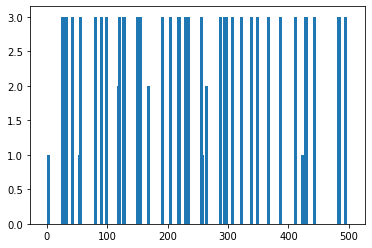

In [ ]:
total_times_selected_with_threshold = times_selected_with_threshold*1 + times_selected_with_threshold_p1*1 + times_selected_with_threshold_m1*1
plt.bar(np.arange(total_times_selected_with_threshold.shape[0]), total_times_selected_with_threshold, width=5)

### point4

In [ ]:
n = [100,250,400]
p = 500
rng = np.random
sparsity = [0.75,0.85,0.95]
total_times_selected = []
for i in range(len(n)):
    for j in range(len(sparsity)):
        X, y, beta = simulate_data(n[i],p,rng,sparsity = sparsity[j])
        X_train, y_train, X_val, y_val = train_test_split(X,y)
        samples_X, samples_y = create_samples(X_train, y_train, 30)
        times_selected = select_features(samples_X,samples_y)
        total_times_selected.append(times_selected)


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.116e+02, tolerance: 2.654e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.142e+01, tolerance: 2.241e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of t

<BarContainer object of 500 artists>

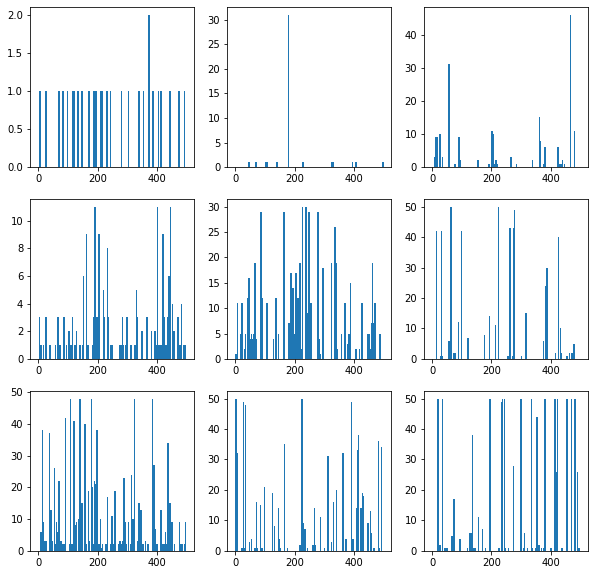

<BarContainer object of 500 artists>

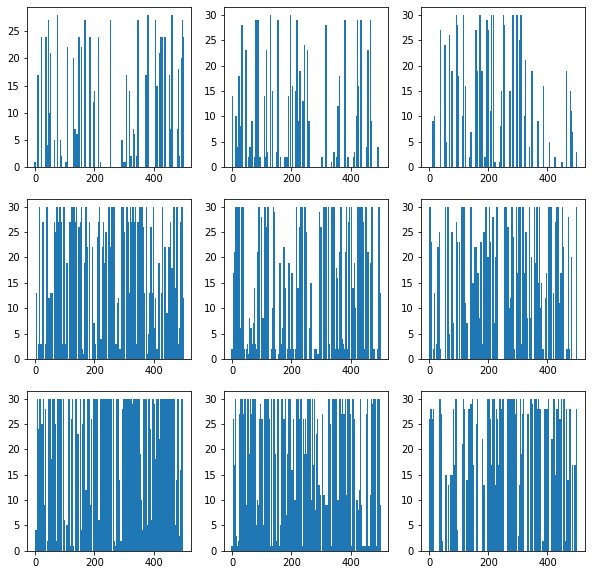

In [ ]:
tot_times_selected = np.array(total_times_selected)
plt.figure(figsize=(10,10))
plt.subplot(331)
plt.bar(np.arange(tot_times_selected.shape[1]), tot_times_selected[0], width=5)
plt.subplot(332)
plt.bar(np.arange(tot_times_selected.shape[1]), tot_times_selected[1], width=5)
plt.subplot(333)
plt.bar(np.arange(tot_times_selected.shape[1]), tot_times_selected[2], width=5)
plt.subplot(334)
plt.bar(np.arange(tot_times_selected.shape[1]), tot_times_selected[3], width=5)
plt.subplot(335)
plt.bar(np.arange(tot_times_selected.shape[1]), tot_times_selected[4], width=5)
plt.subplot(336)
plt.bar(np.arange(tot_times_selected.shape[1]), tot_times_selected[5], width=5)
plt.subplot(337)
plt.bar(np.arange(tot_times_selected.shape[1]), tot_times_selected[6], width=5)
plt.subplot(338)
plt.bar(np.arange(tot_times_selected.shape[1]), tot_times_selected[7], width=5)
plt.subplot(339)
plt.bar(np.arange(tot_times_selected.shape[1]), tot_times_selected[8], width=5)


<BarContainer object of 500 artists>

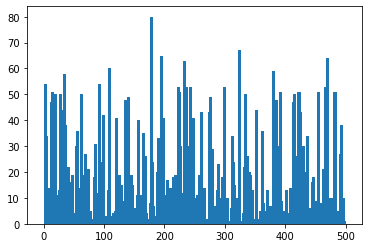

<BarContainer object of 500 artists>

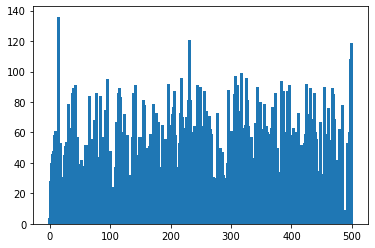

In [ ]:
tot_times_selected_sum = np.sum(tot_times_selected, axis = 0)
plt.bar(np.arange(tot_times_selected_sum.shape[0]), tot_times_selected_sum, width=5)


# Q2

In [ ]:
# kolla på alla lambda samtidigt eller var för sig? 
def create_data_Q2(B=1):
    n = 250
    p = 500
    rng = np.random
    sparsity = 0.85
    N_Samples = 50

    X, y, real_beta = simulate_data(n,p,rng,sparsity = sparsity)
    X_train, y_train, X_val, y_val = train_test_split(X,y)
    samples_X, samples_y = create_samples(X_train, y_train, N_Samples)
    Q2_times_selected = []
    Q2_times_selected_plus1 = []
    Q2_times_selected_minus1 = []
    all_beta_est = []
    for i in range(B):
        times_selected, beta_est = select_features_beta(samples_X,samples_y, add_to_idx=0)
        Q2_times_selected.append(times_selected)
        all_beta_est.append(beta_est)
        times_selected, beta_est_p1 = select_features_beta(samples_X,samples_y, add_to_idx=1)
        Q2_times_selected_plus1.append(times_selected)
        all_beta_est.append(beta_est_p1)
        times_selected, beta_est_m1 = select_features_beta(samples_X,samples_y, add_to_idx=-1)
        Q2_times_selected_minus1.append(times_selected)
        all_beta_est.append(beta_est_m1)
    all_beta_est = np.array(all_beta_est)
    Q2_times_selected = np.array(Q2_times_selected)
    Q2_times_selected_plus1 = np.array(Q2_times_selected_plus1)
    Q2_times_selected_minus1 = np.array(Q2_times_selected_minus1)
    return Q2_times_selected, Q2_times_selected_plus1,Q2_times_selected_minus1, all_beta_est, real_beta



In [ ]:
def get_thresholds(Q2_times_selected):
    Q2_times_selected_with_threshold_70 = 100*np.array(Q2_times_selected[0])/N_Samples >= 70
    Q2_times_selected_with_threshold_80 = 100*np.array(Q2_times_selected[0])/N_Samples >= 80
    Q2_times_selected_with_threshold_90 = 100*np.array(Q2_times_selected[0])/N_Samples >= 90
    return Q2_times_selected_with_threshold_70, Q2_times_selected_with_threshold_80, Q2_times_selected_with_threshold_90


In [ ]:
def plot_all(Q2_times_selected_minus1,Q2_times_selected, Q2_times_selected_plus1):
    threshold_70_minus1,threshold_80_minus1,threshold_90_minus1 = get_thresholds(Q2_times_selected_minus1)
    threshold_70,threshold_80,threshold_90 = get_thresholds(Q2_times_selected)
    threshold_70_plus1,threshold_80_plus1,threshold_90_plus1 = get_thresholds(Q2_times_selected_plus1)
    plt.figure(figsize=(12,6))
    plt.subplot(331)
    plt.bar(np.arange(Q2_times_selected.shape[1]), threshold_70_plus1, width=5)
    plt.title('70%')
    plt.subplot(332)
    plt.bar(np.arange(Q2_times_selected.shape[1]), threshold_80_plus1, width=5)
    plt.title('80%')
    plt.subplot(333)
    plt.bar(np.arange(Q2_times_selected.shape[1]), threshold_90_plus1, width=5)
    plt.title('90%')

    plt.subplot(334)
    plt.bar(np.arange(Q2_times_selected.shape[1]), threshold_70, width=5)
    plt.subplot(335)
    plt.bar(np.arange(Q2_times_selected.shape[1]), threshold_80, width=5)
    plt.subplot(336)
    plt.bar(np.arange(Q2_times_selected.shape[1]), threshold_90, width=5)

    plt.subplot(337)
    plt.bar(np.arange(Q2_times_selected.shape[1]), threshold_70_minus1, width=5)
    plt.subplot(338)
    plt.bar(np.arange(Q2_times_selected.shape[1]), threshold_80_minus1, width=5)
    plt.subplot(339)
    plt.bar(np.arange(Q2_times_selected.shape[1]), threshold_90_minus1, width=5)
    
    

In [ ]:
def select_features_beta(samples_X,samples_y, add_to_idx=0, test_alpha_min=False):
    
    n_folds = 5 
    times_selected = np.zeros(samples_X.shape[2])

    for i in range(samples_X.shape[0]): 
        X, y = samples_X[i], samples_y[i]
        lassoCV = LassoCV(cv=n_folds, random_state=0).fit(X,y)
        alpha = lassoCV.alpha_
        
        cv_mean = np.mean(lassoCV.mse_path_, axis=1)
        cv_std = np.std(lassoCV.mse_path_, axis=1)
        idx_min_mean = np.argmin(cv_mean)
        idx_alpha = np.where(
            (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
            (cv_mean >= cv_mean[idx_min_mean])
        )[0][0]
        alpha_1se = lassoCV.alphas_[idx_alpha + add_to_idx]
        if(test_alpha_min):
            alpha_1se = alpha

        lasso_coef = Lasso(alpha= alpha, random_state=0).fit(X,y).coef_
        lasso_coef = np.array(lasso_coef)
        lasso_1se_coef = Lasso(alpha= alpha_1se, random_state=0).fit(X,y).coef_
        lasso_1se_coef = np.array(lasso_1se_coef)
        beta_est = (lasso_1se_coef != 0).astype(int)
        times_selected += lasso_1se_coef != 0
        #print(times_selected)
    return times_selected, beta_est

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e+01, tolerance: 3.413e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e+01, tolerance: 3.413e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of t

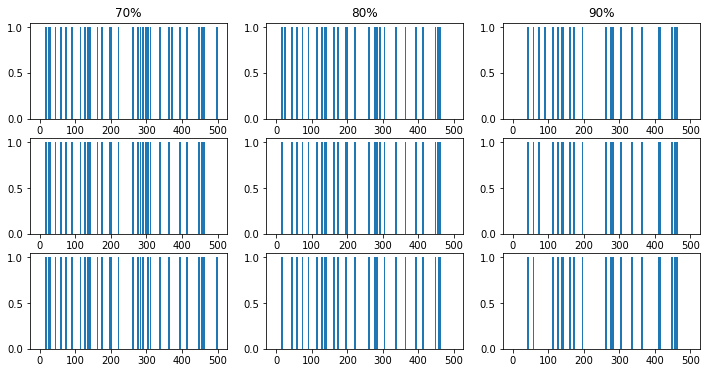

In [ ]:
Q2_times_selected, Q2_times_selected_plus1,Q2_times_selected_minus1, all_beta_est, real_beta  = create_data_Q2()
plot_all(Q2_times_selected_minus1,Q2_times_selected,Q2_times_selected_plus1)


threshold_70_minus1,threshold_80_minus1,threshold_90_minus1 = get_thresholds(Q2_times_selected_minus1)
threshold_70,threshold_80,threshold_90 = get_thresholds(Q2_times_selected)
threshold_70_plus1,threshold_80_plus1,threshold_90_plus1 = get_thresholds(Q2_times_selected_plus1)

#####################################
beta = (real_beta != 0).astype(int)


beta_est = all_beta_est[0] == 0
beta_est_p1 = all_beta_est[1] == 0
beta_est_m1 = all_beta_est[2] == 0

sensitivity = np.sum(beta*beta_est) / np.sum(beta)
sensitivity_p1 = np.sum(beta*beta_est_p1) / np.sum(beta)
sensitivity_m1 = np.sum(beta*beta_est_m1) / np.sum(beta)

beta_zero = beta == 0
beta_est_zero = beta_est == 0
beta_est_p1_zero = beta_est_p1 == 0
beta_est_m1_zero = beta_est_m1 == 0

specificity = np.sum(beta_zero*beta_est_zero) / np.sum(beta == 0)
specificity_p1 = np.sum(beta_zero*beta_est_p1_zero) / np.sum(beta == 0)
specificity_m1 = np.sum(beta_zero*beta_est_m1_zero) / np.sum(beta == 0)





0.7236842105263158
0.7236842105263158
0.7236842105263158
0.08962264150943396
0.06839622641509434
0.0660377358490566
491
497


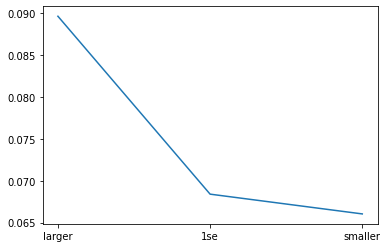

In [ ]:
print(sensitivity_p1)
print(sensitivity)
print(sensitivity_m1)

print(specificity_p1)
print(specificity)
print(specificity_m1)

print((beta_est == beta_est_p1).sum())
print((beta_est == beta_est_m1).sum())

spec = [specificity_p1, specificity, specificity_m1]
d = ['larger','1se','smaller']
plt.plot(d,spec)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f98e27f7-6444-4cf3-8fec-73bc47540f9b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>